<a id="topV"></a>

# Viewing COS Data

# Learning Goals
### This Notebook is designed to walk the user (*you*) through:
#### 1. **[Reading in the data](#readInV) using `Python`**
#### 2. **[Displaying the data](#plottingV) using common plotting techniques**
#### 3. **[Making a quick assessment of the data](#AssessingV) with tools to bin and measure the data's SNR and resolution**
##### $\ \ \ \ $ 3.1. [Understanding and Using Data Quality Flags](#DataQualV)
##### $\ \ \ \ $ 3.2. [Binning the Data](#BinningV)
##### $\ \ \ \ $ 3.3. [Calculating the Signal-to-Noise Ratio](#SnrV)

*If you're confident with Reading-in and Plotting data in Python, you may run the first few cells and then click the link to go ahead and skip to [section 3](#AssessingV).*


# 0. Introduction
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope ([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).

#### This tutorial aims to prepare you to begin analyzing COS data of your choice by walking you through reading and viewing a spectrum obtained with COS, as well as obtaining a few diagnostic measurements of your spectrum.

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).


## We will import the following packages:

- `numpy` to handle array functions (version $\ge$ 1.17)
- `astropy.io` fits for accessing FITS files
- `astropy.table Table` for creating tidy tables of the data
- `astropy.units` and `astropy.visualization.quantity_support` for dealing with units
- `matplotlib.pyplot` for plotting data
- `astroquery.mast Mast and Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive

*Later on, we will import some functions from a local file*, for which we have imported the `sys` package.

In [1]:
# This line is just to make matplotlib look good in a notebook
%matplotlib inline
# Manipulating arrays
import numpy as np
# Our arrays will encounter divide by 0 warnings, which is OK. DO NOT COPY THIS NEXR LINE INTO YOUR CODE WITHOUT CAREFUL CONSIDERATION
np.warnings.filterwarnings('ignore')
# Reading in data
from astropy.io import fits
from astropy.table import Table
# Dealing with units and plotting them
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()
# Plotting
import matplotlib.pyplot as plt
# Downloading data from archive
from astroquery.mast import Mast
from astroquery.mast import Observations
from astroquery.mast import Catalogs

import sys # We need import to look in the directory above this one when we look for some functions later.
sys.path.append('../') 

## We will also define a few directories in which to place our data and plots, as well as a few colors we will use in plots later.

In [2]:
# These will be important directories for the notebook
cwd = !pwd
cwd = cwd[0]

!mkdir ./data
!mkdir ./output/
!mkdir ./output/plots

datadir = cwd + '/data/'
outputsdir = cwd + '/output/'
plotsdir = cwd + '/output/plots/'

# A few colors for plotting - feel free to change these!
segment_colors = {'FUVA':'#BC8C5B', 'FUVB':'#4B6CA4', 'NUVA':'#1813CE','NUVB':'#61946E','NUVC':'#8C1A11'}

mkdir: ./data: File exists
mkdir: ./output/: File exists
mkdir: ./output/plots: File exists


## We will be working with some FUV and NUV datasets downloaded in the cell below. Searching for and downloading data is out of the scope of this tutorial. If you wish to learn more, please see our [tutorial on downloading COS data](#NEEDSLINK!)

In [3]:
nuv_downloads = Observations.download_products(Observations.get_product_list(Observations.query_criteria(obs_id = 'lbbd01020')), # GET the NUV data on WD1057+719 with the G230L grating; only the _x1dsum and _asn
                                           download_dir=datadir , extension='fits', mrp_only=True, cache=False)

fuv_downloads = Observations.download_products(Observations.get_product_list(Observations.query_criteria(obs_id = 'lcxv13050')), # GET the NUV data on WD1057+719 with the G230L grating; only the _x1dsum and _asn
                                           download_dir=datadir , extension='fits', mrp_only=True, cache=False)

**If you're confident Reading-in and Plotting data in Python, go ahead to [Section 3](#AssessingV)**

<a id="readInV"></a>
# 1. Reading in the data

The calibrated spectrum data is now on our local machine as: **`current-working-directory`**`/data/mastDownload/HST/`**`Obs_id`**`/`**`Obs_id`**`_x1dsum.fits`,
where the NUV and FUV Data are contained in the obs_ids:

| Spectral Region | Obs_id| Object Name|Object Type|filepath|
|-----|------------|------|-----------|--------|
| FUV | LCXV13050|QSO| 3C48 |  ./data/mastDownload/HST/lbbd01020|
| NUV | LBBD01020|Star| WD1057 + 719 |  ./data/mastDownload/HST/lcxv13050|

## 1.1. Investigating the Data - *Basics*
We want to learn a bit about this file, then input the data.

We can learn a great deal about our data from its primary fits header (see cell below).

In [4]:
fuv_x1d_filepath = './data/mastDownload/HST/lcxv13050/lcxv13050_x1dsum.fits' # Make sure these point to your new FUV data!
fuv_asn_filepath = './data/mastDownload/HST/lcxv13050/lcxv13050_asn.fits'    # This is the association file

nuv_x1d_filepath = './data/mastDownload/HST/lbbd01020/lbbd01020_x1dsum.fits' # Make sure these point to your new NUV data!
nuv_asn_filepath = './data/mastDownload/HST/lbbd01020/lbbd01020_asn.fits'    # This is the association file


nuv_header_x1d = fits.getheader(nuv_x1d_filepath)
nuv_header_asn = fits.getheader(nuv_asn_filepath)

fuv_header_x1d = fits.getheader(fuv_x1d_filepath)
fuv_header_asn = fits.getheader(fuv_asn_filepath)

fuv_header_x1d[:18],"...",fuv_header_x1d[45:50] #This is the main 0th header of the calibrated nuv spectrum; THIS IS NOT THE WHOLE THING!

(SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                    8 / array data type                                
 NAXIS   =                    0 / number of array dimensions                     
 EXTEND  =                    T                                                  
 NEXTEND =                    1 / Number of standard extensions                  
 DATE    = '2020-10-16'         / date this file was written (yyyy-mm-dd)        
 FILENAME= 'lcxv13050_x1dsum.fits' / name of file                                
 FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                 
 TELESCOP= 'HST'                / telescope used to acquire data                 
 INSTRUME= 'COS   '             / identifier for instrument used to acquire data 
 EQUINOX =               2000.0 / equinox of celestial coord. system             
                

For instance, we notice that the NUV data was taken in [TIME-TAG mode](https://hst-docs.stsci.edu/cosdhb/chapter-5-cos-data-analysis/5-4-working-with-time-tag-data) and calibrated with `calCOS` version `3.3.9`

However, some metadata information, such as the time of observation and calculated exposure time, can be found in the **1st header** rather than the 0th. We will read and print this below:

In [5]:
with fits.open(fuv_x1d_filepath) as hdu:
    fuv_header1_x1d = hdu[1].header
    fuv_date = fuv_header1_x1d['DATE-OBS']
    fuv_time = fuv_header1_x1d['TIME-OBS']
    fuv_exptime = fuv_header1_x1d['EXPTIME']
    
    #It's also perfectly valid to access the 1st extension header using 'fits.getheader(fuv_x1d_filepath, ext=1)'

print(f"This FUV data was taken on {fuv_date} starting at {fuv_time} with a net exposure time of {fuv_exptime} seconds.")
    
with fits.open(nuv_x1d_filepath) as hdu:
    nuv_header1_x1d = hdu[1].header
    nuv_date = nuv_header1_x1d['DATE-OBS']
    nuv_time = nuv_header1_x1d['TIME-OBS']
    nuv_exptime = nuv_header1_x1d['EXPTIME']

print(f"This NUV data was taken on {nuv_date} starting at {nuv_time} with a net exposure time of {nuv_exptime} seconds.")

This FUV data was taken on 2016-06-13 starting at 23:56:29 with a net exposure time of 6532.512 seconds.
This NUV data was taken on 2009-08-14 starting at 06:03:56 with a net exposure time of 999.136 seconds.


## 1.2. Reading in the `x1d` Main Data
#### The simplest way to read in the `x1d` data from fits extension \#1 is using the [`astropy.table.getdata`](https://docs.astropy.org/en/stable/io/fits/api/files.html#astropy.io.table.getdata) command.
We can then display all the fields contained in this data table using the `.colnames` method. You can ignore the warnings about multiple slashes that come up while reading in the data. The proper units are displayed in LaTex as:

- 'erg /s /cm\**2 /angstrom'  ==> $$\ \ erg\ s^{-1}\ cm^{-2}\ \overset{\circ}{A}^{-1}$$
- 'count /s /pixel'          ==> $$\ \ counts\ s^{-1}\ pixel^{-1}$$

#### In the case of the FUV data, we see an astropy style table of 2 rows (*FUVA and FUVB* - see next python cell). These rows contain data from the 2 segments of FUV Detector (see figure 1.1).

### Fig. 1.1 from [COS DHB Fig. 1.6](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-2-cos-physical-configuration#id-1.2COSPhysicalConfiguration-Figure1.6)

<center>
    <img src=figures/cosdhb_fig1p6.jpg width ="900" title="Layout of the COS FUV detector">
    <figcaption>Layout of the COS FUV detector. Note that FUVB corresponds to shorter wavelengths than FUVA.</figcaption>
</center>

#### In the case of the NUV data, we see a similar astropy style table of 3 rows (*NUVA, NUVB, and NUVC* - see next python cell). These rows contain data from the 3 stripes of the NUV spectrum (see figure 1.2).

### Fig. 1.2 from [COS DHB Fig. 1.10](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-2-cos-physical-configuration#id-1.2COSPhysicalConfiguration-Figure1.10)

<center>
    <img src=figures/ch1_cos_overview3.10.jpg width ="900" title="An example COS NUV spectrum">
    <figcaption>An example COS NUV spectrum. These are the lower three stripes labeled 'PSA'. The upper stripes, labeled 'WCA' are for wavelength calibration.</figcaption>
</center>

<br/><br/>

The columns of these tables include some scalar values which *describe* the data (i.e. EXPTIME), while the columns containing actual data hold it in lists of equal length (i.e. WAVELENGTH, FLUX, etc., where that length = NELEM).

An important thing to note about this *NUV* data in particular is that with the grating used here (G230L), segment C is actually a 2nd order spectrum with a higher dispersion (x2) and ~5% contamination from the 1st order spectrum. See the [COS Data Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-1-instrument-capabilities-and-design), *especially Fig. 1.3,* for more information.

In [6]:
fuv_x1d_data = Table.read(fuv_x1d_filepath)
columns = fuv_x1d_data.colnames

print("\n\nTable of FUV data with columns:\n",columns, "\n\n")

fuv_x1d_data



Table of FUV data with columns:
 ['SEGMENT', 'EXPTIME', 'NELEM', 'WAVELENGTH', 'FLUX', 'ERROR', 'ERROR_LOWER', 'GROSS', 'GCOUNTS', 'VARIANCE_FLAT', 'VARIANCE_COUNTS', 'VARIANCE_BKG', 'NET', 'BACKGROUND', 'DQ', 'DQ_WGT'] 




SEGMENT,EXPTIME,NELEM,WAVELENGTH [16384],FLUX [16384],ERROR [16384],ERROR_LOWER [16384],GROSS [16384],GCOUNTS [16384],VARIANCE_FLAT [16384],VARIANCE_COUNTS [16384],VARIANCE_BKG [16384],NET [16384],BACKGROUND [16384],DQ [16384],DQ_WGT [16384]
,s,,Angstrom,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),ct / s,ct / s,ct,ct,ct,ct,ct / s,ct / s,,
bytes4,float64,int32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32
FUVA,6532.512,16384,1610.2408431826216 .. 1810.944873479704,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0
FUVB,6532.512,16384,1421.9464486806014 .. 1622.5958114281107,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0


## 1.3. The Association `asn` file

#### It's also likely we will want to see what observations went into making this calibrated spectrum. This information is contained in the Association (`asn`) file, under the MEMNAME column.

In [7]:
print(fits.info(fuv_asn_filepath),'\n\n----\n')
fuv_asn_data = Table.read(fuv_asn_filepath)
print(fuv_asn_data)

Filename: ./data/mastDownload/HST/lcxv13050/lcxv13050_asn.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  ASN           1 BinTableHDU     25   5R x 3C   [14A, 14A, L]   
None 

----

   MEMNAME        MEMTYPE     MEMPRSNT
-------------- -------------- --------
     LCXV13FLQ         EXP-FP        1
     LCXV13FXQ         EXP-FP        1
     LCXV13G4Q         EXP-FP        1
     LCXV13GXQ         EXP-FP        1
     LCXV13050        PROD-FP        1


We see that our data has MEMTYPE = `PROD-FP`, meaning it is an Output science product, see COS DHB [Table 2.6](https://hst-docs.stsci.edu/cosdhb/chapter-2-cos-data-files/2-4-cos-data-products).
This particular association file lists four `EXP-FP` (Input science exposure), with the `MEMNAME` (Dataset IDs) `[LCXV13FLQ, LCXV13FXQ, LCXV13G4Q, LCXV13GXQ]`. We could look for these datasets, if we needed the raw data.

### Exercise 1.1. *Finding Metadata for the NUV*
1. Read in the NUV data, just as we did with the FUV data.
2. From the 0th header of the `x1dsum` file, determine the time (in MJDs) that the data was processed. (keyword = PROCTIME) and from the 1th header, determine how many wavelength calibration "flashes" were used (keyword = NUMFLASH)
3. From the `asn` file, determine how many input science exposures went into the NUV x1dsum file.

In [8]:
### Your code here




<a id="plottingV"></a>
# 2. Plotting our Data

## 2.1. Plotting an FUV Spectrum

#### Let's grab the simplest data we need to plot a spectrum: **WAVELENGTH, FLUX, and ERROR**.
- *Note that here, ERROR is flux error.*
- *Also note that somewhat counterintuitively, the FUVB segment extends over shorter wavelengths than the FUVA.*

### 2.1.1. Our First Plot

#### We begin with an extremely simple plot: simply a line plot of a single segment (FUVA) without its error.
The goal of this show is to demonstrate some of the common parameters of making a simple plot with `matplotlib` which you are likely to often need. The comments explain what each line does.

<a id="fig2p1"></a>

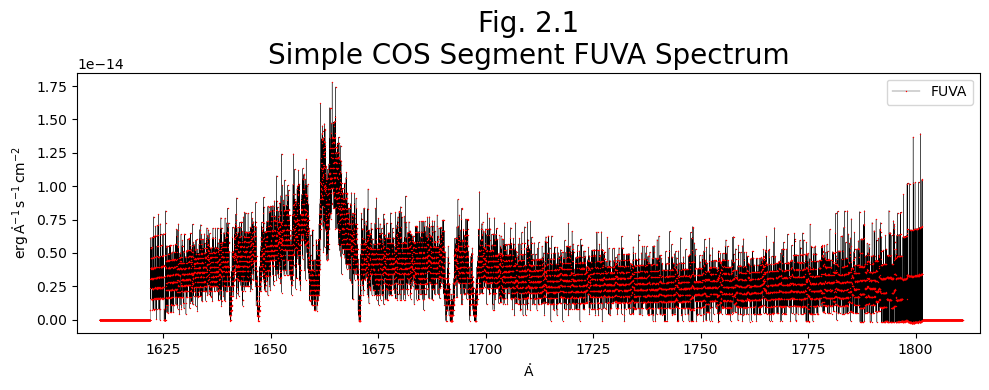

In [9]:
wvln, flux, segment  = fuv_x1d_data[0]["WAVELENGTH", "FLUX", "SEGMENT"] # [0] Accesses FUVA, the longer wvln segment and gets the data we need to plot a spectrum
wvln *= u.AA # Adds unit to the wvln of Aangstroms
flux *= u.erg/( u.second *u.AA * (u.cm)**2) # Adds unit to the flux of erg / (Angstrom cm2 s)

with quantity_support(): # Allows us to view the astropy units attached to the data as the axes labels. This line isn't generally necessary unless you want the unit support.
    
    fig1, ax = plt.subplots(1,1,figsize=(10,4), dpi = 100)  # Sets up the plot as a single box with size of 10x4 inches, and with a dpi of 100, relavent should we choose to save it
    
    # The next few lines are the core of the cell, where we actually place the data onto the plot:
    ###############
    ax.plot(wvln, flux, # First two arguments are assumed to be the x-data, y-data
            linestyle = "-", linewidth = 0.25, c = 'black', # These parameters specify the look of the connecting line
            marker = '.', markersize = 2, markerfacecolor = 'r', markeredgewidth = 0, # The marker parameters specify how the data points will look - if you don't want dots set marker = ''
            label = segment) # The label is an optional parameter which will allow us to create a legend - useful when there are multiple datasets on the same plot
    
    ax.set_title("Fig. 2.1\nSimple COS Segment FUVA Spectrum", size = 20) # Adds a title of fontsize 20 points
    
    plt.xlim(1605,1815) # These two lines set the x and y bounds of the image in whatever units we are plotting in 
    plt.ylim(-1E-15, 1.85E-14)
    
    plt.legend(loc = 'upper right') # Adds a legend with the label specified in the plotting call
    plt.tight_layout() # Gets rid of blank space
    plt.savefig(plotsdir + "Fig2.1.png") # Optionally you can save the plot as an image
    plt.show() # Shows all the plot calls in this cell and "clears" the plotting space - must come after any saving you want to do

### Exercise 2.1
Plot the data from Segment FUVB, similar to the Segment FUVA plot above, but this time, normalize flux to a max of 1, and don't plot those distracting red markers!

Note what can you simply copy over, and what you have to make sure to change.

In [10]:
# Your code here




### 2.1.2. A Complex Look at the Entire FUV

#### Now that we have an idea for how `matplotlib` works, let's make a more complicated graph showing both FUV segments - *independently and together*.

One of the most important steps to creating a plot is planning out how it will look and convey its information - so let's start out by planning this out below:

|Panel|Contents|Information Conveyed|Notes|
|-|-|-|-|
|*top*|Entire FUV Spectrum as a **simple plot**|Overview of the entire spectrum we have, course look without much detail|Color by segment|
|*middle*|Shorter Wavelength FUVB Spectrum as an **errorbar plot**|Closer look at the shorter wavelength spectrum with an idea of error|Color errorbar by segment, central line in black|
|*bottom*|Longer Wavelength FUVA Spectrum as an **errorbar plot**|Closer look at the longer wavelength spectrum with an idea of error|Color errorbar by segment, central line in black|

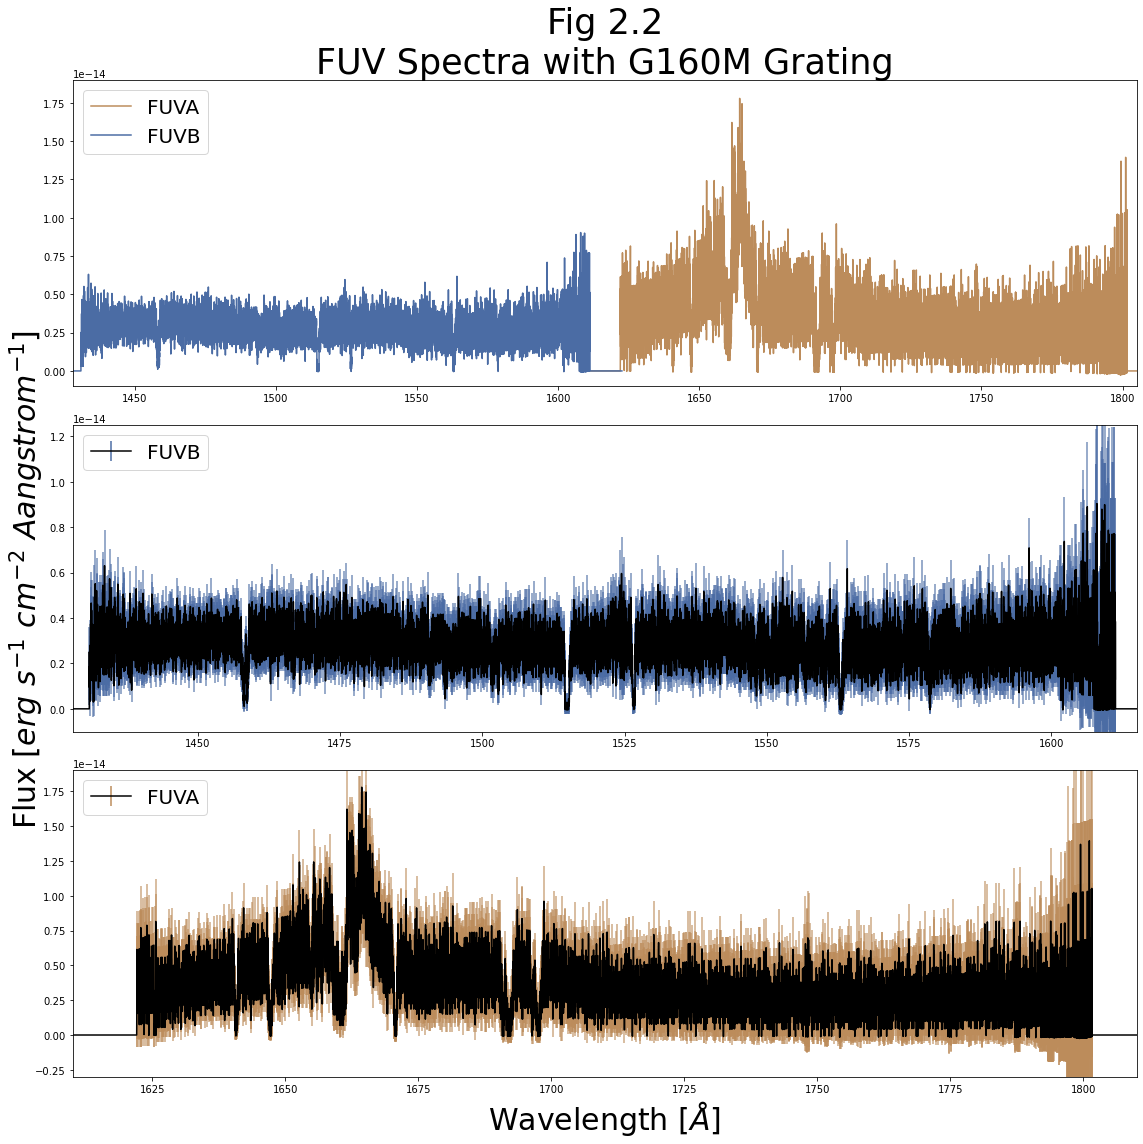

In [11]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize = (16, 16)) # ax0, ax1, ax2 are our 3 panels: top, middle, and bottom

for i in range(2): # Repeats for i = [0,1] to apply to each segment's data at a time
    wvln, flux, fluxErr, segment = fuv_x1d_data[i]["WAVELENGTH", "FLUX", "ERROR", "SEGMENT"] # Grabs all useful data for the chosen segment
    
    # This section applies to the top panel:
    ax0.plot(wvln, flux,
                linestyle = "-", label = segment, c = segment_colors[segment])
    ax0.legend(fontsize = 20 , loc = 'upper left')
    ax0.set_title("Fig 2.2\nFUV Spectra with G160M Grating", size = 35)
    ax0.set_xlim(1428,1805)
    ax0.set_ylim(-1E-15,1.9E-14)

    ######
    
    if i == 0: # This indented code applies only to segment FUVA data in bottom Panel 
        markers, caps, bars = ax2.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "-",  label = segment, marker = '', markersize = 1,
                                           c = 'k', alpha = 1, ecolor = segment_colors[segment] )
        ax2.set_xlim(1610,1810)
        ax2.set_ylim(-3E-15,1.9E-14)
        ax2.legend(fontsize = 20 , loc = 'upper left')
        ax2.set_xlabel('Wavelength [$\AA$]', size = 30)
        [bar.set_alpha(0.75) for bar in bars]
        
    ######
        
    if i == 1: # This indented code applies only to segment FUVB data in middle Panel 
        markers, caps, bars = ax1.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "-",  label = segment, c = 'k', ecolor =  segment_colors[segment] )
        ax1.set_xlim(1428,1615)
        ax1.set_ylim(-1E-15,1.25E-14)
        ax1.legend(fontsize = 20 , loc = 'upper left')
        ax1.set_ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 30)
        [bar.set_alpha(0.75) for bar in bars]
    
    ######
plt.tight_layout()
plt.savefig(plotsdir + 'Fig2.2.png', dpi = 200)
plt.show()

### 2.1.3. Looking Closer at parts of the FUV Spectrum 

#### Now, it's almost impossible to get any insights on small-scale details in the above plots - there's simply too high a data density. Below, we'll show examples of:
- Plotting a small region around an absorption line feature.
- Plotting an entire segment's spectrum in chunks of wavelength space.

#### Let's begin with showing a region around a line, in this case, we see a sharp line around 1670 Å. 
This is around the wavelength of Al II (1670.79 Å).

Text(0.5, 1.0, 'Fig. 2.3\nZoom in on the line at 1670 $\\AA$')

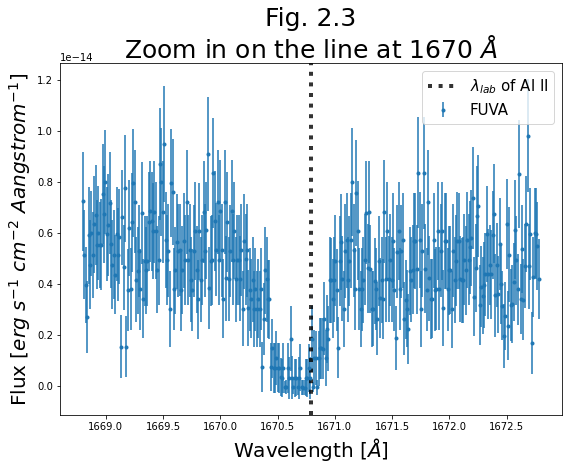

In [12]:
lineAl2 = 1670.79 #Leitherer, Claus, et al. The Astronomical Journal 141.2 (2011): 37.

wvln, flux, fluxErr, segment = fuv_x1d_data[0]["WAVELENGTH", "FLUX", "ERROR", "SEGMENT"] # Grabs all useful data for the chosen segment

wvln_extent = 2 # How many aangstroms in each direction around lineAl2 do we want to look at?

lineRegion_mask = (wvln>lineAl2 - wvln_extent) & (wvln<lineAl2 +wvln_extent) # Mask the data to within +/- wvln_extent Aangstrom of the line - this makes the plots run quicker
wvln_region, flux_region, fluxErr_region = wvln[lineRegion_mask], flux[lineRegion_mask], fluxErr[lineRegion_mask]

plt.figure(figsize=(8, 6))
plt.axvline(lineAl2, c = 'k', linewidth = 4 , linestyle = 'dotted', alpha = 0.8,  label = "$\lambda_{lab}$ of Al II")

plt.errorbar(wvln_region, flux_region, fluxErr_region, label = 'FUVA',
            linestyle = '', marker = '.')

plt.xlabel('Wavelength [$\AA$]', size = 20)
plt.ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 20)

plt.legend( fontsize = 15)
plt.tight_layout()
plt.savefig(plotsdir + 'Fig2.3.png', dpi = 200)
plt.title("Fig. 2.3\nZoom in on the line at 1670 $\AA$", size = 25)

#### It's tempting to assume that because this line is close to a somewhat common spectral line (Al II) that it must correspond to that line...
#### But CAUTION! 
<img src=figures/warning.png width ="60" title="CAUTION!"> 
Remember the source we're looking at - the quasar 3C48. This quasar can be expected to have a substantial redshift, and indeed it does. $$z \approx 0.37$$  

Source: [Simbad search for 3C48](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=3c48&submit=SIMBAD+search)

Indeed, at that redshift, we see this line to be an entirely different wavelength: $\approx 1218$ Å. This is close to, and likely corresponds to, Lyman-$\alpha$ emission, rather than Al II.

##### This somewhat misleading line provides an excellent reminder to take what you know about the source into consideration.

#### Now we will create a much more complex plot, allowing us to visualize an entire segment's spectrum in fine detail
We'll split the spectrum into "chunks" of \~10 Aangstroms, and plot the chunks in a vertical series. These plots may take a minute to create. If you want them to run quicker, hit the `Interrupt the Kernel` square-shaped button, and run this cell with a smaller nRows.
<a id="fig2p4V"></a>

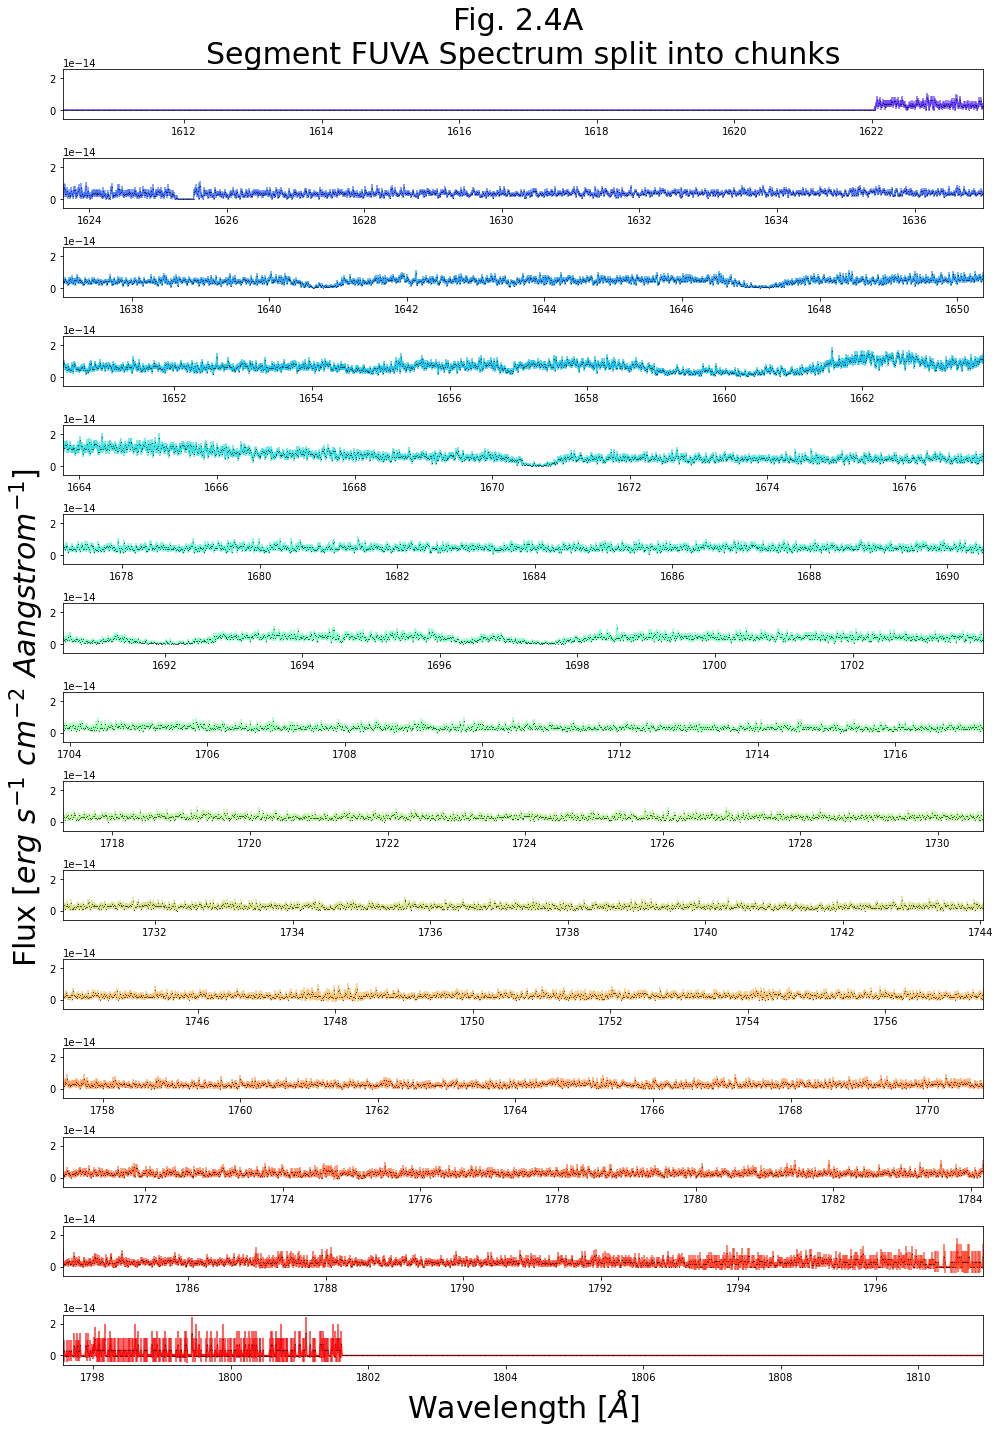


----



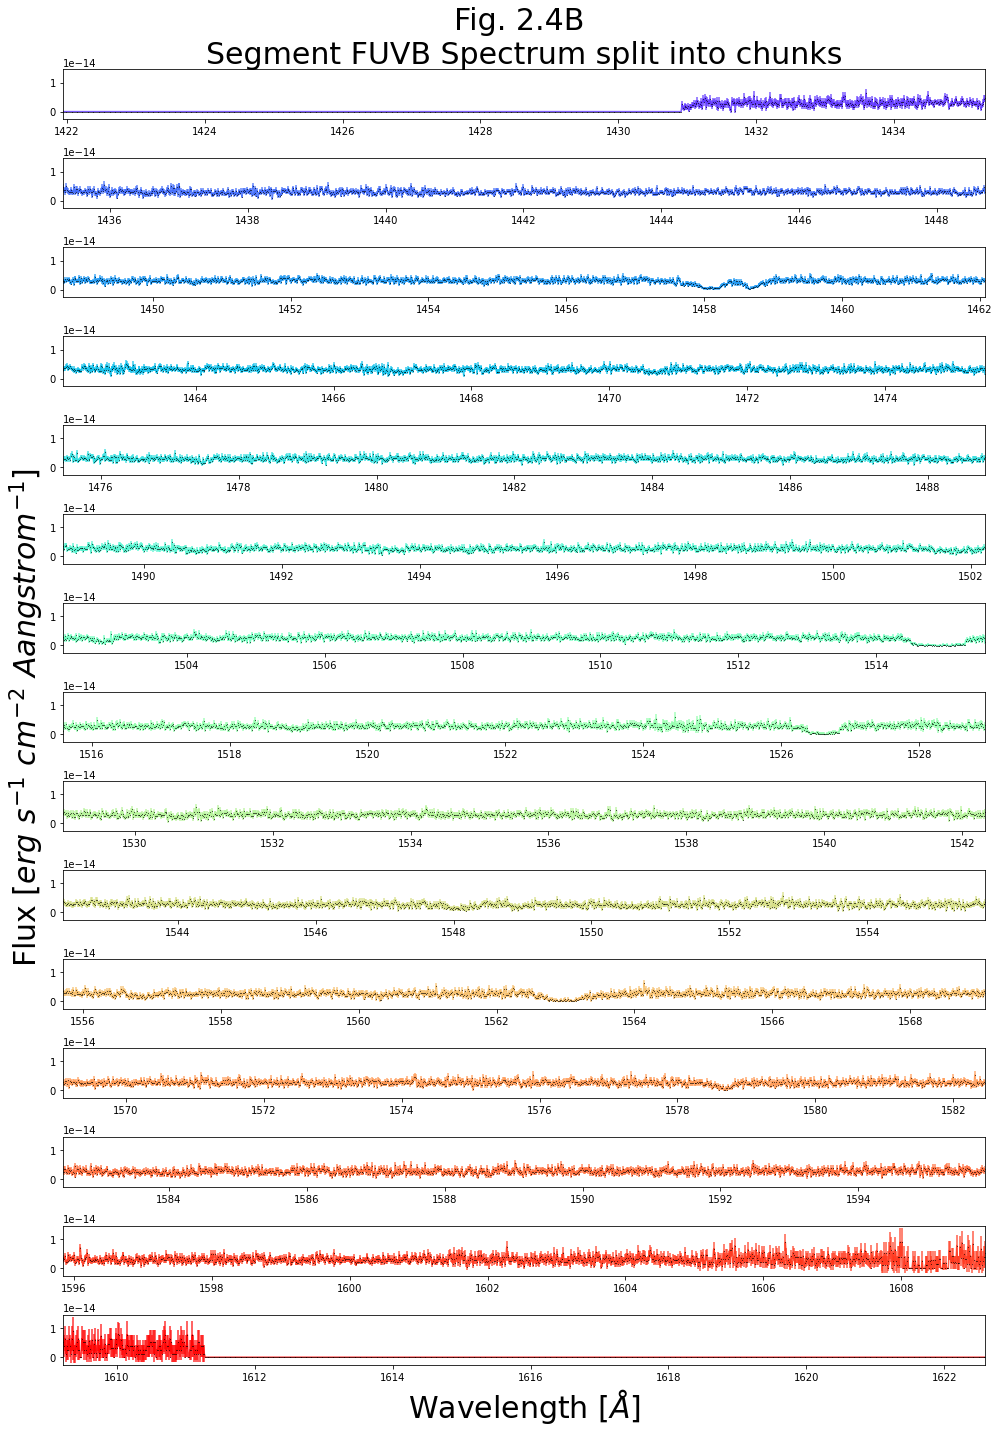


----

CPU times: user 22.1 s, sys: 915 ms, total: 23 s
Wall time: 23 s


In [13]:
%%time
for i in range(2): # Repeats for i = [0,1] to apply to each segment's data at a time
    wvln, flux, fluxErr, segment = fuv_x1d_data[i]["WAVELENGTH", "FLUX", "ERROR", "SEGMENT"] # Grabs all useful data for the chosen segment
    
    minx, maxx = min(wvln), max(wvln)
    miny, maxy = min(flux), max(flux)
    rangex = maxx - minx
    fig = plt.figure(figsize = (14,20))

    nRows = 15

    for i in range(nRows):
        min_ = minx + i*rangex/nRows
        max_ = minx + (i+1)*rangex/nRows
        ax = plt.subplot(nRows,1, i+1)
        
        if i == 0: # A way to set Title, xlabel, and ylabel that will work INDEPENDENT of number of rows
            ax.set_title(f"Fig. 2.4{segment[-1]} \nSegment {segment} Spectrum split into chunks", size = 30)
        if i == nRows - 1:
            ax.set_xlabel("Wavelength [$\AA$]", size = 30)
        if i == int(nRows/2):
            ax.set_ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 30)
            
            
        ax.errorbar(wvln,flux,fluxErr, c = plt.cm.rainbow((i+1)/nRows), alpha = 0.8, 
                    marker = '.', markerfacecolor = 'k', markersize = 2, mew = 0)

        ax.set_xlim(min_, max_)
    plt.tight_layout()
    plt.savefig(plotsdir + f'Fig2.4{segment[-1]}_{nRows}Rows_seg{segment}.png', dpi = 200)
    plt.show()
    print("\n----\n")

### Exercise 2.2 Choosing and plotting a useful data range
That last plot was a bit **excessive!** Make a scaled down version from just `1635 - 1675` Aangstroms, and plot the data as a simple line graph.

In [14]:
# Your code here




### 2.1.4. Reading and plotting the data with `specutils`
### *OPTIONAL*

An alternative way to read in and work with spectral data is with the [`specutils` package](https://specutils.readthedocs.io/en/stable/), which contains *quite a bit of functionality* for working with spectra. It also can make dealing with units easier, as it generally works well with astropy units and other modules. Make sure that your package is up to date, this should run with (version $\ge$ 1.1)

`specutils` treats spectra as python objects rather than lists, and reads in the entire spectrum over both segments. 

Below is a simple example of using `specutils` to read-in, plot, and continuum-normalize our entire spectrum.

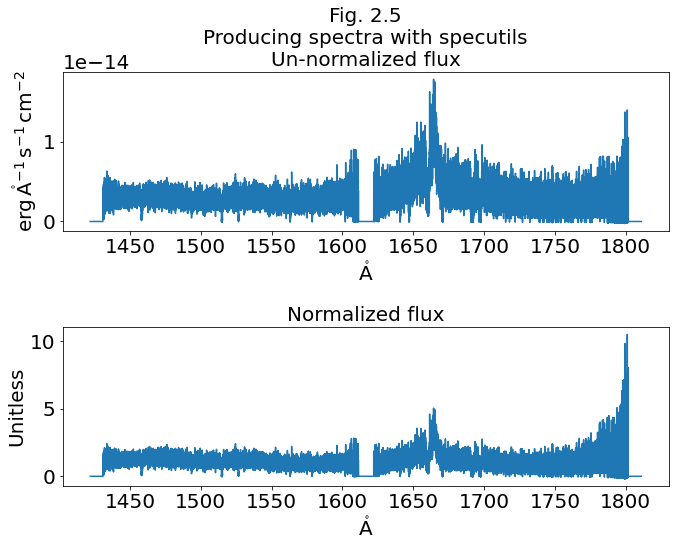

In [15]:
import specutils
from specutils.fitting import fit_generic_continuum

from matplotlib import rcParams
rcParams.update({'font.size': 20}) # The default fontsize it will use does not look good at this size

spec1d = specutils.Spectrum1D.read(fuv_x1d_filepath)

fig, (ax0,ax1) = plt.subplots(2,1,figsize = (10,8))

#Plot the non-normalized flux
ax0.plot(spec1d.spectral_axis , spec1d.flux)
ax0.set_title("Fig. 2.5\nProducing spectra with specutils\nUn-normalized flux", size = 20)

# Continuum Normalize the flux:
cont_norm_spec1d = spec1d /fit_generic_continuum(spec1d)(spec1d.spectral_axis) 

#Plot the normalized flux
ax1.plot(cont_norm_spec1d.spectral_axis , cont_norm_spec1d.flux)
ax1.set_title("Normalized flux", size = 20)
ax1.set_ylabel("Unitless")
# ax1.set_xlabel(ax2.xlabel, size = 20)

plt.tight_layout()
plt.savefig(plotsdir+'Fig2.5.png', dpi = 200)
plt.show()

wvln, flux, fluxErr = spec1d.wavelength, spec1d.flux, spec1d.uncertainty.quantity # Not necessary for this plot, but gives us all the data separately
# segment = spec1d.meta['header']['APMPOS'][-4:] # since the spec1d contains multiple segments, it doesn't actually make sense to get this keyword; however if you need to be able to access the segment, this should work

`specutils` also works with the visualization [package `Jdaviz.Specviz`](https://github.com/spacetelescope/jdaviz), to produce very useful interactive spectral plots within a jupyter notebook GUI framework. Currently, this interactive program works well within the Jupyter Notebook environment, but not within Jupyter Lab environment. You can learn more about working with `Specviz` in our [other training here.](#NEEDS_LINK!)

## 2.2. Plotting an NUV Spectrum

The NUV data is formatted very similarly to the FUV data, and can be accessed as in [Section 1](#readInV).

In [16]:
# Here we read in the data - it is ok to ignore any warnings about slashes in the notation
nuv_x1d_data = Table.read(nuv_x1d_filepath)

### 2.2.1. Examining the first-order spectrum

#### Again, let's grab the simplest data we need to plot a spectrum: **WAVELENGTH, FLUX, and ERROR**.

We will limit this first plot to only our first order spectra (so we will exclude segment C). We will plot these two spectra together (in the top panel) and then segment-by-segment in the lower 2 panes, similar to fig. 2.2.
- The former view gives a better sense of the continuum
- The latter views show zooms which allow us to meaningfully view the errors and see specific emission/absorption features.

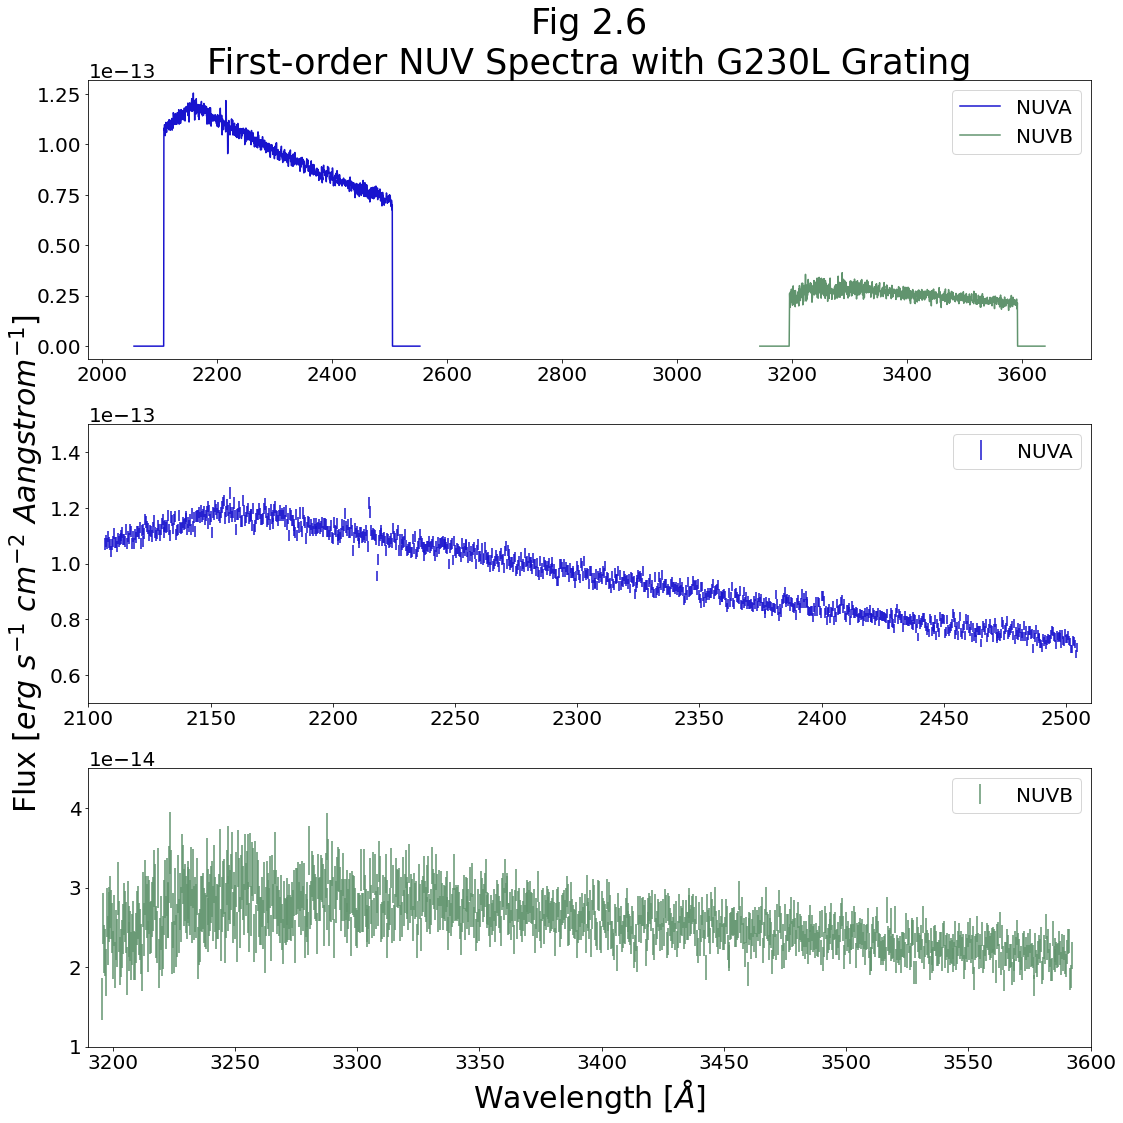

In [17]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize = (16, 16))

for i in range(2):
    wvln, flux, fluxErr, segment = nuv_x1d_data[i]["WAVELENGTH"], nuv_x1d_data[i]["FLUX"], nuv_x1d_data[i]["ERROR"], nuv_x1d_data[i]["SEGMENT"]

    ax0.plot(wvln, flux,
                linestyle = "-", label = segment, c = segment_colors[segment])
    ax0.legend(fontsize = 20 )
    ax0.set_title("Fig 2.6\nFirst-order NUV Spectra with G230L Grating", size = 35)
    
    if i == 0:
        ax1.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = segment_colors[segment] )
        ax1.set_xlim(2100,2510)
        ax1.set_ylim(0.5E-13,1.5E-13)
        ax1.legend(fontsize = 20 )
        ax1.set_ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 30)
        
    if i == 1:
        ax2.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = segment_colors[segment] )
        ax2.set_xlim(3190,3600)
        ax2.set_ylim(1E-14,4.5E-14)
        ax2.legend(fontsize = 20 )
        ax2.set_xlabel('Wavelength [$\AA$]', size = 30)

plt.tight_layout()
plt.savefig(plotsdir+'Fig2.6.png', dpi = 200)
plt.show()

### 2.2.3. Examining the second-order spectrum

On segment C, we have a more dispersed spectrum over a smaller chunk of the NUV. Below, we plot this portion over the first-order spectrum from segment A.


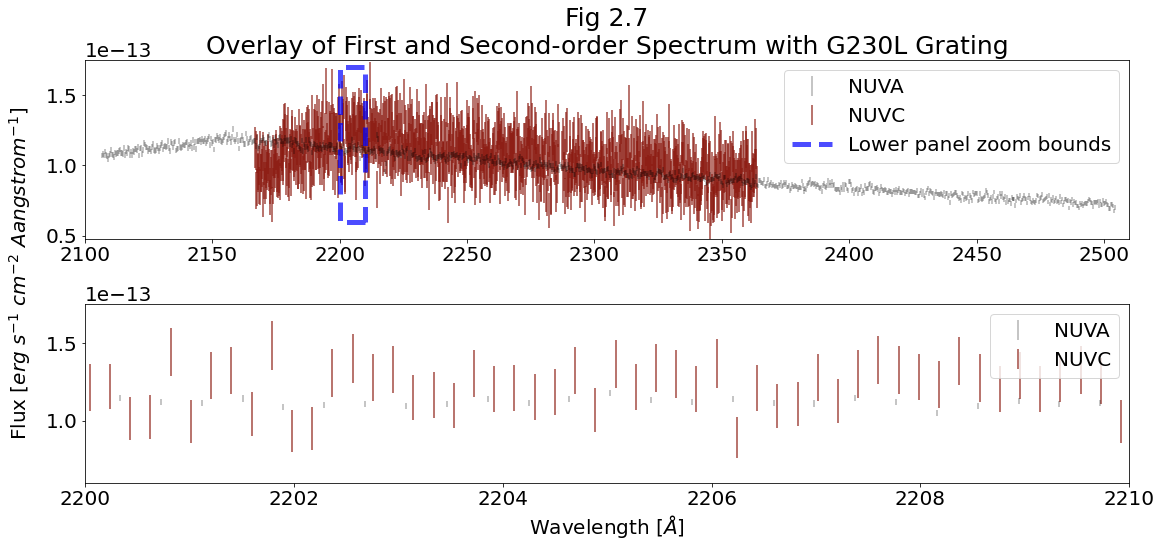

In [18]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize = (16, 8))

for i in [2,0]: #We reverse this order, so that the 0th segment (A) is plotted OVER the 2nd segment (C). It's purely aesthetic
    wvln, flux, fluxErr, segment = nuv_x1d_data[i]["WAVELENGTH"], nuv_x1d_data[i]["FLUX"], nuv_x1d_data[i]["ERROR"], nuv_x1d_data[i]["SEGMENT"]
    
    if i == 0:
        ax0.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = 'k', alpha = 0.3)
        
        ax1.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = 'k', alpha = 0.3)
        
    if i == 2:
        ax0.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = segment_colors[segment] , alpha = 0.8)
        
        ax1.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = segment_colors[segment] , alpha = 0.8)

 
ax0.set_xlim(2100,2510)
ax0.set_ylim(0.48E-13,1.75E-13)

ax0.set_title("Fig 2.7\nOverlay of First and Second-order Spectrum with G230L Grating", size = 25)

ax1.set_xlim(2200,2210)
ax1.set_ylim(0.6E-13,1.75E-13)

ax1.set_xlabel('Wavelength [$\AA$]', size = 20)
fig.text(-0.015, 0.5, 'Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 20, va='center', rotation='vertical')       

#Let's add a dashed rectangle to show where we are zooming into in the lower panel.
ax0.plot([2210,2200,2200,2210,2210],[0.6E-13,0.6E-13,1.7E-13,1.7E-13,0.6E-13], 
        'b', linewidth = 5, linestyle = '--', alpha = 0.7, label = "Lower panel zoom bounds")


handles,labels = ax0.get_legend_handles_labels() # These lines just ensure that the legend is ordered correctly (first ax0)
handles = [handles[2], handles[1], handles[0]]
labels = [labels[2], labels[1], labels[0]]
ax0.legend(handles, labels, fontsize = 20 , loc = 'upper right')
handles,labels = ax1.get_legend_handles_labels() # Now for ax1
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]
ax1.legend(handles,labels, fontsize = 20 , loc = 'upper right')

plt.tight_layout()
plt.savefig(plotsdir+'Fig2.7.png', dpi = 200)
plt.show()

##### Clearly, our errorbars on the second-order spectrum are *much larger*. 
However, if we need a very high dispersion, for instance, to split close-together lines, the lower panel (zoom) shows a potential advantage of segment C. Its higher spectral sampling rate can allow for finer distinctions in wavelength, if an acceptable SNR can be reached.

<a id = AssessingV></a>
# 3. Preliminary Review of the Data

##### There's no one-size-fits-all approach to analyzing COS data. 

**This section aims to walk you through taking a quick but critical look at your data by taking the first steps of [binning](https://en.wikipedia.org/wiki/Data_binning) the data, for instance to the size of COS' resolution elements ([resel](https://hst-docs.stsci.edu/cosihb/chapter-3-description-and-performance-of-the-cos-optics/3-2-size-of-a-resolution-element)), and then measuring the Signal-to-Noise Ratio ([SNR](https://en.wikipedia.org/wiki/Signal-to-noise_ratio)).**



#### The cell below is only necessary if you have chosen to skip sections #1 and #2

In [19]:
fuv_x1d_filepath = './data/mastDownload/HST/lcxv13050/lcxv13050_x1dsum.fits' # Make sure these point to your new FUV data!
fuv_x1d_data = Table.read(fuv_x1d_filepath)
nuv_x1d_filepath = './data/mastDownload/HST/lbbd01020/lbbd01020_x1dsum.fits' # Make sure these point to your new NUV data!
nuv_x1d_data = Table.read(nuv_x1d_filepath)

<a id = DataQualV></a>
## 3.1. Data Quality and Initial Cleanup

One of the first things one notices in all of the plots we have made is that all of the segments have real, useful data, bookended on each size by zeros (see, for example, [Fig. 2.1](#fig2p1)).
These zeros are regions on the active area of the detector which don't receive and detect light, but *are* read in as data. We don't want these data in our spectra, so we'll filter them out. The COS data we have downloaded conveniently has an extension devoted to data quality information. Information on the data quality array and the flags it contains can be found in [Table 2.18 of the COS Data Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-2-cos-data-files/2-7-error-and-data-quality-array).

Let's first look at the data quality flags. We'll do this by plotting a histogram, labelling the bins according to what the data quality value of that bin means.

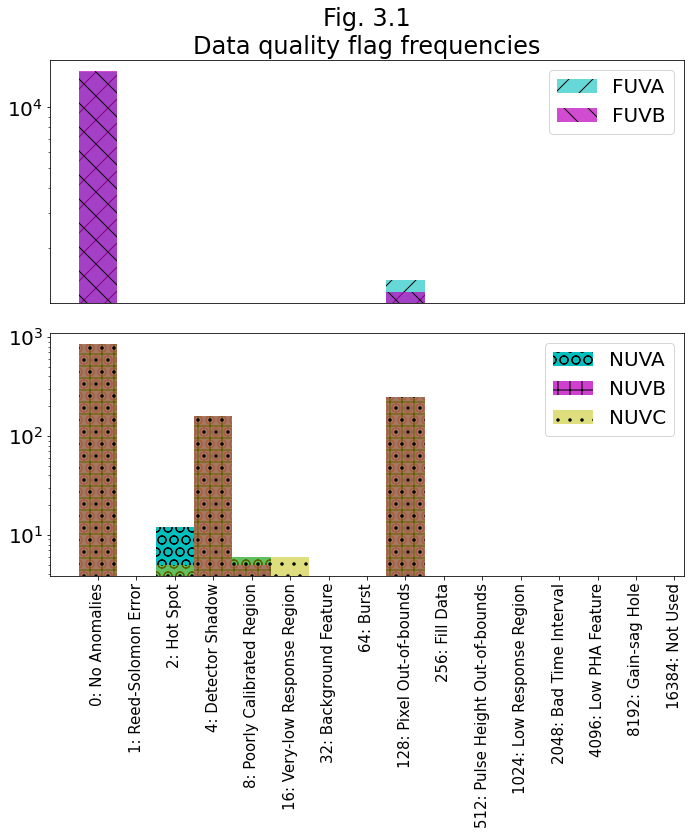

In [20]:
bins_titles = (np.logspace(-1,14, 16,base=2, dtype=int)) # The values are all powers of two from 2**1 to 2**14, except for 0, which is 2**-inf
meanings = ['No Anomalies', 'Reed-Solomon Error', 'Hot Spot', 'Detector Shadow', 'Poorly Calibrated Region', # What each power of 2 means in order
            'Very-low Response Region', 'Background Feature', 'Burst', 'Pixel Out-of-bounds', 'Fill Data', 
            'Pulse Height Out-of-bounds', 'Low Response Region', 'Bad Time Interval', 'Low PHA Feature', 
           'Gain-sag Hole', 'Not Used']

meanings2 = [str(bt)+": "+ mn for bt, mn in zip(bins_titles, meanings)]

fig, (ax0,ax1) = plt.subplots(2,1,figsize = (10,12))

for i in range(2): # First loop through the 2 FUV segments
    dataQual, segment = fuv_x1d_data[i]["DQ"], fuv_x1d_data[i]["SEGMENT"]

    bins_ = np.arange(-1,15)
    bins_titles = (np.logspace(-1,14, 16,base=2, dtype=int))

    logDQ = np.log2(dataQual)
    logDQ = np.nan_to_num(logDQ, neginf = -1)    
    
    ax0.set_xticks([])
    ax0.hist(logDQ , bins = bins_, color = 'cmy'[i], alpha =0.5+ 0.1*(i+1) , label = segment, hatch = '/\\*'[i])
    ax0.legend()
    ax0.set_yscale('log')
    ax0.set_title("Fig. 3.1\nData quality flag frequencies")

for i in range(3): # Next loop through the 3 NUV segments
    dataQual, segment = nuv_x1d_data[i]["DQ"], nuv_x1d_data[i]["SEGMENT"]

    bins_ = np.arange(-1,15)

    logDQ = np.log2(dataQual)
    logDQ[np.where(-1*(logDQ) == np.inf)] = -1

    ax1.hist(logDQ , bins = bins_, color = 'cmy'[i], alpha = 1 - 0.25*(i) , label = segment, hatch = 'O+.'[i])
    ax1.legend()
    ax1.set_yscale('log')
    
    
plt.xticks(bins_+0.5, labels = meanings2, rotation = 'vertical', fontsize = 15)
fig.set_tight_layout('tight')
plt.savefig(plotsdir+'Fig3.1.png', dpi = 200)

When the data is processed through `calCOS`, it has a series of "Serious Data Quality" [SDQ](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-4-descriptions-of-spectroscopic-calibration-steps) flags attached to it in the form of a single integer between 0 and $2^{15}$. This value is found in the 1-th header as `"SDQFLAGS"`. This can be decomposed into the powers of 2 data flags above, and tells the pipeline whether to weight that pixel by 0 or 1. These weights are then stored in the `x1d` and `x1dsum` files, in the `"DQ_WGT"` column.

Below, we first see *which* data quality flags the pipeline considered "serious", and then demonstrate masking out the datapoints assigned a weight of 0.

In [21]:
sdqFlags_fuv = fits.getheader(fuv_x1d_filepath,1)["SDQFLAGS"]
print(f"The FUV was processed with SDQFLAGS = {sdqFlags_fuv}, which in binary is {bin(sdqFlags_fuv)[2:]}")
print("\t\tThus, the following DQ-flagged data get weighted by 0:\n")
for i, char in enumerate(bin(sdqFlags_fuv)[2:]):
    if char =='1':
        print(f"\t\t\t{(2**(i+1))}'s place - ", meanings[i+2])

The FUV was processed with SDQFLAGS = 8346, which in binary is 10000010011010
		Thus, the following DQ-flagged data get weighted by 0:

			2's place -  Hot Spot
			128's place -  Pixel Out-of-bounds
			1024's place -  Low Response Region
			2048's place -  Bad Time Interval
			8192's place -  Gain-sag Hole


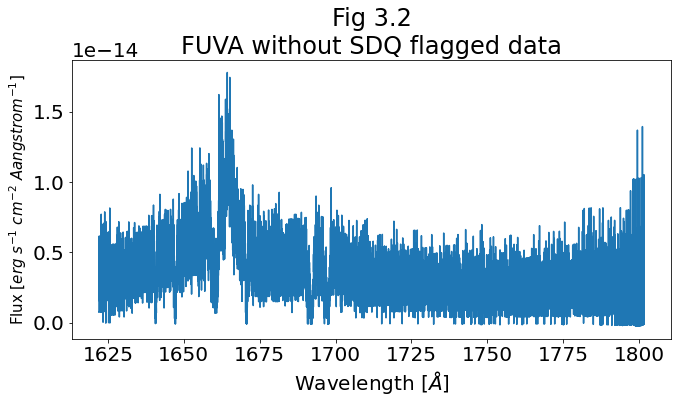

In [22]:
mask_noSDQ = np.ndarray.astype(fuv_x1d_data[0]["DQ_WGT"], bool)
wvln_FUVA_noSDQ, flux_FUVA_noSDQ = fuv_x1d_data[0]["WAVELENGTH"][mask_noSDQ], fuv_x1d_data[0]["FLUX"][mask_noSDQ]
plt.figure(figsize = (10,6))
plt.plot(wvln_FUVA_noSDQ,flux_FUVA_noSDQ)
plt.title("Fig 3.2\nFUVA without SDQ flagged data")
plt.xlabel('Wavelength [$\AA$]', size = 20)
plt.ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 15)
plt.tight_layout()
plt.savefig(plotsdir+'Fig3.2.png', dpi = 200)

Alternatively, we can ignore the SDQFLAGS and the weights decided by `calCOS` and pick which data quality flags we want to filter out. From Fig 3.1, we know the only problem in the FUV and the largest problem in the NUV are pixels flagged by **"out of bounds"**, corresponding to Data Quality: **128**.

We will demonstrate removing only these datapoints from the FUV data below. You could also filter to only data with *0: no anomalies*, or to any other subset.

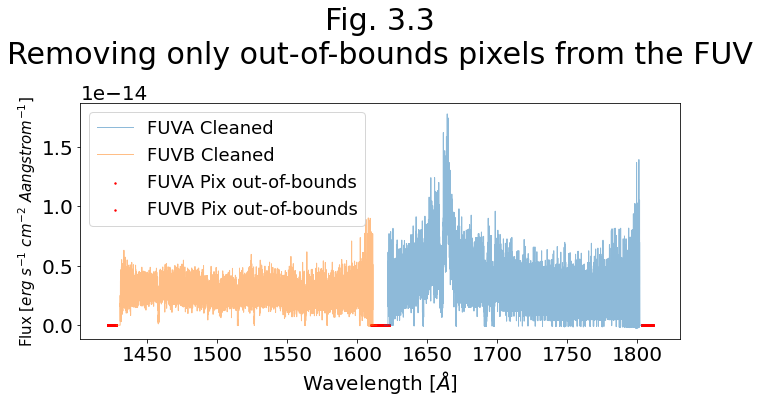

In [23]:
plt.figure(figsize = (10,6))
for i in range(2):
    wvln, flux, fluxErr, dataQual, segment = fuv_x1d_data[i]["WAVELENGTH"], fuv_x1d_data[i]["FLUX"],\
    fuv_x1d_data[i]["ERROR"], fuv_x1d_data[i]["DQ"], fuv_x1d_data[i]["SEGMENT"]


    plt.plot(wvln[dataQual != 128.0], flux[dataQual != 128.0], linewidth = 1, alpha = 0.5, 
             label = f"{segment} Cleaned")
    plt.scatter(wvln[dataQual == 128.0], flux[dataQual == 128.0], s = 2, c = 'r', alpha = 1, 
                label = f"{segment} Pix out-of-bounds")
plt.legend(fontsize = 18)
plt.title("Fig. 3.3\nRemoving only out-of-bounds pixels from the FUV\n", size = 30)
plt.xlabel('Wavelength [$\AA$]', size = 20)
plt.ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 15)
plt.tight_layout()
plt.savefig(plotsdir+'Fig3.3.png', dpi = 200)

### Exercise 3.1: *Removing all flagged data from the NUV*

The NUV data has flags for more than just out-of-bounds pixels.

1. Filter out all data which has been flagged
2. Plot the NUV spectrum from segments NUVA and NUVB
3. Plot the flagged data in another color to see where the removed data is

In [24]:
# Your answer here




<a id=BinningV></a>
## 3.2. Binning 

Up until now, the data we've been working with has one value per pixel of the detector.
COS data is generally binned to a resolution element, or [resel](https://hst-docs.stsci.edu/cosihb/chapter-3-description-and-performance-of-the-cos-optics/3-2-size-of-a-resolution-element), when working with it. These resels are *generally* the following sizes *in pixels*.

||FUV|NUV|
|-|---|---|
|**Dispersion Axis**|6|3|
|**Cross-Dispersion Axis**|10|3|

So, for the FUV, we generally want to preliminarily bin our x1d or x1dsum data by 6.

In the next few cells below, we define two functions:
1. `downsample_1d`, for binning an array 
2. `binByResel`, which applies this binning to an entire COS NUV or FUV dataset

### 3.2.1. Creating Some Useful Functions for Binning

In [25]:
from Scripts.Useful_COS_Functions import downsample_1d

In addition to reading through this first function `downsample_1d`  in the `Scripts` folder, we can learn about it by calling the python function `help`:

In [26]:
help(downsample_1d)

Help on function downsample_1d in module Scripts.Useful_COS_Functions:

downsample_1d(myarr, factor, weightsarr=[-1], weighted=True, in_quad=False)
    Downsamples a 1D array by averaging over *factor* pixels; Crops right side if the shape is not a multiple of factor; Can do in quadrature, and weighted.
    
    Parameters:
    myarr (numpy array): numpy arrayf to be downsampled/binned.
    factor (int) : how much you want to rebin the array by.
    weightsarr (numpy array) : numpy array by which to weight the average; Unnecessary if weighted == False.
    weighted (bool) : Default True. Is this an unweighted mean or a weighted average
    in_quad (bool) : Default False. Do you want to average/sum in quadrature?
    
    Returns:
    (numpy array) downsampled myarr binned by factor, cropped to an integer multiple of factor.
    
    Citation:
    Credit to Rachel Plesha for the initial inspiration on this. Rachel cited "Adam Ginsburg's python codes".



#### We see that the function `downsample_1d` can optionally (1) average a given bin's in quadrature and/or (2) weight the averages by a value.
1. Working in quadrature is useful for dealing with errors. See [Uncertainty propogration](https://en.wikipedia.org/wiki/Propagation_of_uncertainty).
2. Some pixels receive more total exposure time than their neighbors, because of how x1d and x1dsum files are created. Pixels with more exposure time should be weighted higher.

##### In the next cell, we import a function, `binByResel`, that applies this downsampling selectively to all the data we have read in from a single COS x1dsum file.

In [27]:
from Scripts.Useful_COS_Functions import binByResel
help(binByResel)

Help on function binByResel in module Scripts.Useful_COS_Functions:

binByResel(data_table, binsize=6, weighted=True, verbose=True)
    Bins an entire COS dataset (in astropy Table form); does errors in quadrature; weights averages by a pixel's exposure time.
    
    Parameters:
    data_table (Table) : Astropy Table of COS spectral data.
    binsize (int) : What to bin by. 
    weighted (bool) : Whether to weight the averages by exposure time of a pixel; Default is True.
    verbose (bool) : Whether to print major steps the function is taking; Default is True.
    
    Returns:
    Table : New binned table of values



#### `binByResel` gives us a new table where all of the data is sensibly binned, such that errors are summed in quadrature, and each pixel's values are weighted by their exposure time.
### 3.2.2. Binning the FUV Data
#### Below we bin our FUV data by 6. Our resulting table is just under $\dfrac{1}{6}$ the size of our input table, as a few of the last datapoints were cropped.

In [28]:
# from astropy.table import Table
binned_fuv_data = binByResel(fuv_x1d_data)
print(f"\nOriginal Dataset Length is {len(fuv_x1d_data[0]['WAVELENGTH'])}")
print(f"Binned   Dataset Length is {len(binned_fuv_data[0]['WAVELENGTH'])}")
print(f"\t{len(fuv_x1d_data[0]['WAVELENGTH'])} over {len(binned_fuv_data[0]['WAVELENGTH'])} = {len(fuv_x1d_data[0]['WAVELENGTH'])/len(binned_fuv_data[0]['WAVELENGTH'])}\n")
binned_fuv_data

function `BinByResel` is Binning by 6

Original Dataset Length is 16384
Binned   Dataset Length is 2730
	16384 over 2730 = 6.0014652014652015



EXPTIME,WAVELENGTH [2730],FLUX [2730],ERROR [2730],ERROR_LOWER [2730],GROSS [2730],GCOUNTS [2730]
float64,float64,float32,float32,float32,float32,float32
6532.512,1610.2714700565607 .. 1810.8652436074628,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0
6532.512,1421.977067212425 .. 1622.5162032453686,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0


<a id=SnrV></a>
## 3.3. Estimating the Signal-to-Noise (SNR) Ratio
### 3.3.1.  Defining a Useful Function for Estimating SNR
Below, we define a function to estimate the SNR of our data. One way to estimate the SNR for photon-counting instruments like COS is by the square-root of their number of gross counts. This is a simplification of the equation given for point sources in the [COS Instrument Handbook Section 7.3](https://hst-docs.stsci.edu/cosihb/chapter-7-exposure-time-calculator-etc/7-3-sensitivity-count-rate-and-signal-to-noise):

$$\dfrac{Signal}{Noise} = \dfrac{C \times t}{\sqrt{C \times t + N_{pix} \times (B_{sky} + B_{det}) \times t}}$$

For bright point sources, $C >> B_{sky} + B_{det}$, and this approaches the simpler:

$$\dfrac{Signal}{Noise} = \sqrt{C \times t} = \sqrt{Gross\ Counts}$$

#### Caution!
<img src=figures/warning.png width ="60" title="CAUTION!"> 
This simplification may not hold very well if your source is diffuse or faint.

In [29]:
from Scripts.Useful_COS_Functions import estimate_SNR
help(estimate_SNR)

Help on function estimate_SNR in module Scripts.Useful_COS_Functions:

estimate_SNR(data_table, snr_range=[-1, -1], bin_data_first=False, binsize_=6, weighted=False, verbose=True)
    Gets an estimate of the Signal to Noise Ratio (SNR), either over wvln-range or whole spectrum, using Poisson noise assumption SNR ~sqrt(N_Counts).
    Weights the SNR 
    
    Parameters:
    data_table (Astropy Table) : astropy table of COS data.
    snr_range (list) : list of two values - [wvln_range_start , wvln_range_end]; Default is [-1,-1], indicating that we will take over all values.
    bin_data_first (bool) : Should we begin by binning the data by the binsize_? Default is False.
    binsize_ (int) : If bin_data_first == True, what to bin by; Default is 6 for fuv resel.
    weighted (bool) : Do you want the average to be an exposure time weighted average rather than the default unweighted mean; Default is False.
    verbose (bool) : Whether to give a few print statements; default is True.
    
 

#### The function `estimate_SNR` gives a $\sqrt{Gross\ Counts}$ estimate of SNR for an input Astropy Table of COS data.
By default, it does not bin the data before calculating the SNR, nor does it weight the output SNR by exposure time; however, it has the functionality to do both. In most cases, a range should be specified over which to calculate the SNR. If no range is specified, then SNR will be computed for all Resels, but no mean/weighted average will be computed; instead, -1 will be returned in place of the mean.

### 3.3.2. Choosing a Region to calculate SNR

The SNR should be calculated over a region of continuum, rather than one with significant spectral lines.
Looking back to [Fig. 2.4](#fig2p4V), we see a broad stretch with no obvious lines from [1675 - 1690$\overset{\circ}{A}$] in the FUVA segment. We'll make a quick plot of that region below just to check.

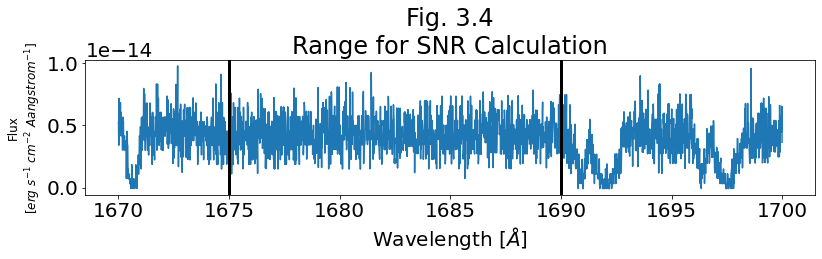

In [30]:
plt.figure(figsize = (12,4))
wvln, flux = fuv_x1d_data[0]["WAVELENGTH", "FLUX"]
wvln_range_mask = (wvln > 1670) & (wvln < 1700)
plt.plot(wvln[wvln_range_mask], flux[wvln_range_mask])
plt.axvline(1675, c = 'k', linewidth = 3)
plt.axvline(1690, c = 'k', linewidth = 3)
plt.title("Fig. 3.4\nRange for SNR Calculation")
plt.xlabel('Wavelength [$\AA$]', size = 20)
plt.ylabel('Flux\n[$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 12)
plt.tight_layout()
plt.savefig(plotsdir+'Fig3.4.png', dpi = 200)

Our chosen region, between the black lines, looks quite good for calculating SNR, as it is free of lines.
### 3.2.3. Calculating the SNR
Below, we calculate the SNR of the FUV data over the region [1675, 1690]. Note, we input the unbinned data, and bin by an FUV Resel of 6 first. We'll leave `verbose = True`, so we can see what is going on in the function.

First, Binning the data by  6
function `BinByResel` is Binning by 6
In range on 0-th segment with limits: 1610.2714700565607 1810.8652436074628 
Unweighted mean SNR over the range [1675, 1690] is: 3.3208043575286865
Out of range on 1-th segment with limits: 1421.977067212425 1622.5162032453686


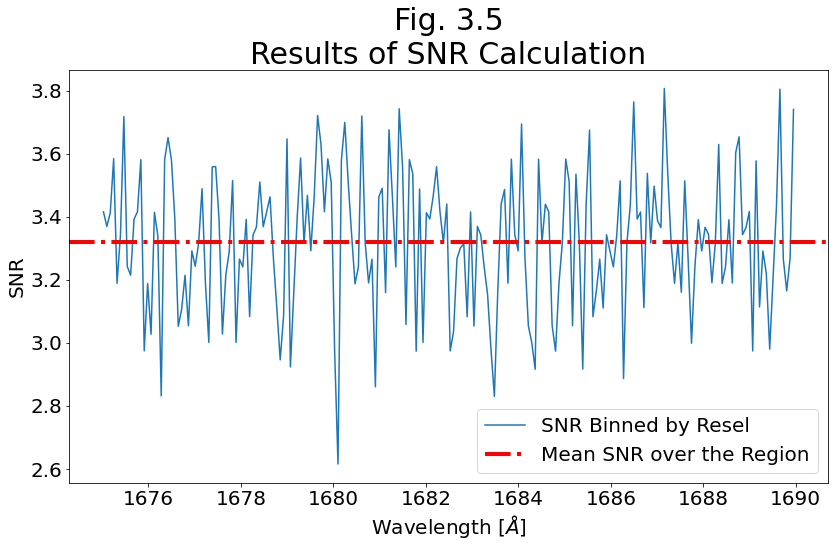

In [31]:
# Calculates the SNR
meanSNR_range1675_1690, range1675_1690 = estimate_SNR(fuv_x1d_data, bin_data_first=True, binsize_=6, snr_range = [1675,1690])
#Creates a plot
plt.figure(figsize = (12,8))
plt.plot(range1675_1690[0][0], range1675_1690[0][1], label = "SNR Binned by Resel")
plt.axhline(meanSNR_range1675_1690, c = 'r', linestyle = '-.', linewidth = 4, label = "Mean SNR over the Region")
plt.legend(fontsize = 20)
plt.title("Fig. 3.5\nResults of SNR Calculation", size = 30)
plt.xlabel('Wavelength [$\AA$]', size = 20)
plt.ylabel('SNR', size = 20)
plt.tight_layout()
plt.savefig(plotsdir+'Fig3.5.png', dpi = 200)

### Exercise 3.2. *Binning the NUV Data and Calculating its SNR*

1. Bin the NUV data, remembering that the resel size is different than that for the FUV
2. Find a continuum region of the NUV data with no significant spectral lines
3. Calculate the mean SNR over that region

In [32]:
# Your code here




## Congratulations! You finished this notebook!
### There are more COS data walkthrough notebooks on different topics. You can find them [here](https://github.com/spacetelescope/COS-Notebooks).


---
## About this Notebook
**Author:** [Nat Kerman](nkerman@stsci.edu)

**Updated On:** 2020-10-26


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*>*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#topV)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 



<br></br>
<br></br>
<br></br>

## Exercise Solutions:

In [33]:
# Exercise 1.1 Soln
###1
# Here we read in the data - it is ok to ignore any warnings about slashes in the notation
nuv_x1d_data = Table.read(nuv_x1d_filepath)
###2
nuv_header_x1d = fits.getheader(nuv_x1d_filepath)
nuv_header1_x1d = fits.getheader(nuv_x1d_filepath, ext = 1)
print(f"Processed at MJD = {nuv_header_x1d['PROCTIME']}\nTaken with {nuv_header1_x1d['NUMFLASH']} wavecal flashes\n" )
###3
nuv_asn_data = Table.read(nuv_asn_filepath)
print(nuv_asn_data)

Processed at MJD = 59137.93144676
Taken with 1 wavecal flashes

   MEMNAME        MEMTYPE     MEMPRSNT
-------------- -------------- --------
     LBBD01HPQ         EXP-FP        1
     LBBD01020        PROD-FP        1


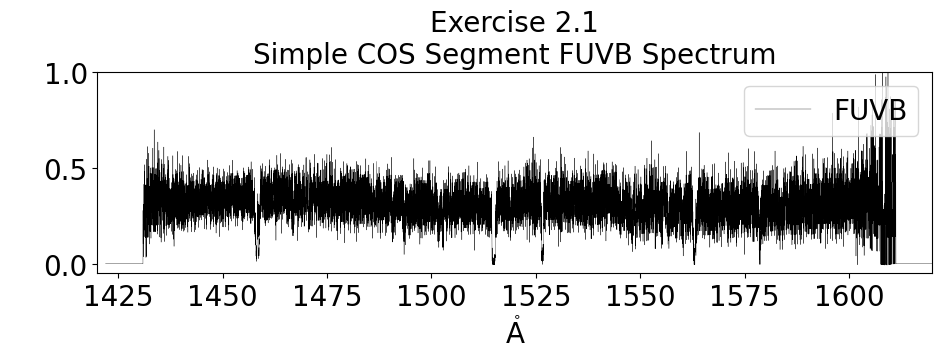

In [34]:
# Ex. 2.1 Soln:
wvln, flux, segment  = fuv_x1d_data[1]["WAVELENGTH", "FLUX", "SEGMENT"] # [0] Accesses FUVA, the longer wvln segment and gets the data we need to plot a spectrum
wvln *= u.AA # Adds unit to the wvln of Aangstroms
flux *= u.erg/( u.second *u.AA * (u.cm)**2) # Adds unit to the flux of erg / (Angstrom cm2 s)
flux/= (np.nanmax(flux))
with quantity_support(): # Allows us to view the units attached to the data as the axes labels. This isn't generally necessary unless you want the unit support.
    
    fig1, ax = plt.subplots(1,1,figsize=(10,4), dpi = 100)  # Sets up the plot as a single box with size of 10x4 inches, and with a dpi of 100, relavent should we choose to save it
    
    # The next few lines are the core of the cell, where we actually place the data onto the plot:
    ###############
    ax.plot(wvln, flux, # First two arguments are assumed to be the x-data, y-data
            linestyle = "-", linewidth = 0.25, c = 'black', # These parameters specify the look of the connecting line
            marker = '',# The marker parameters specify how the data points will look - if you don't want dots set marker = ''
            label = segment) # The label is an optional parameter which will allow us to create a legend - useful when there are multiple datasets on the same plot
    
    ax.set_title("Exercise 2.1\nSimple COS Segment FUVB Spectrum", size = 20) # Adds a title of fontsize 20 points
    
    plt.xlim(1420,1620) # These two lines set the x and y bounds of the image in whatever units we are plotting in 
    plt.ylim(-0.05, 1)
    
    plt.legend(loc = 'upper right') # Adds a legend with the label specified in the plotting call
    plt.tight_layout() # Gets rid of blank space
    plt.show() # Shows all the plot calls in this cell and "clears" the plotting space - must come after any saving you want to do

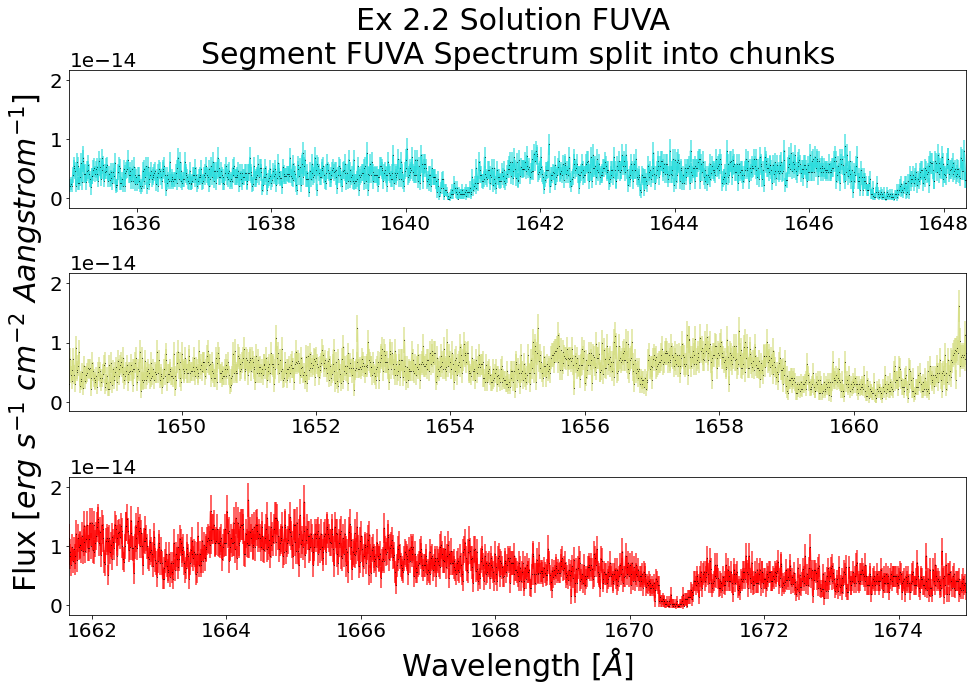

In [35]:
# Ex. 2.2 Soln
wvln, flux, fluxErr, segment = fuv_x1d_data[0]["WAVELENGTH", "FLUX", "ERROR", "SEGMENT"] # Grabs all useful data for the chosen segment = FUVA

minx, maxx = 1635, 1675
miny, maxy = min(flux), max(flux)

wvln_range_mask = (wvln > minx) & (wvln < maxx)

wvln = wvln[wvln_range_mask]
flux = flux[wvln_range_mask]
fluxErr = fluxErr[wvln_range_mask]

rangex = maxx - minx
fig = plt.figure(figsize = (14,10))

nRows = 3

for i in range(nRows):
    min_ = minx + i*rangex/nRows
    max_ = minx + (i+1)*rangex/nRows
    ax = plt.subplot(nRows,1, i+1)

    if i == 0: # A way to set Title, xlabel, and ylabel that will work INDEPENDENT of number of rows
        ax.set_title(f"Ex 2.2 Solution FUV{segment[-1]} \nSegment {segment} Spectrum split into chunks", size = 30)
    if i == nRows - 1:
        ax.set_xlabel("Wavelength [$\AA$]", size = 30)
    if i == int(nRows/2):
        ax.set_ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 30)


    ax.errorbar(wvln,flux,fluxErr, c = plt.cm.rainbow((i+1)/nRows), alpha = 0.8, 
                marker = '.', markerfacecolor = 'k', markersize = 2, mew = 0)

    ax.set_xlim(min_, max_)
plt.tight_layout()
plt.show()

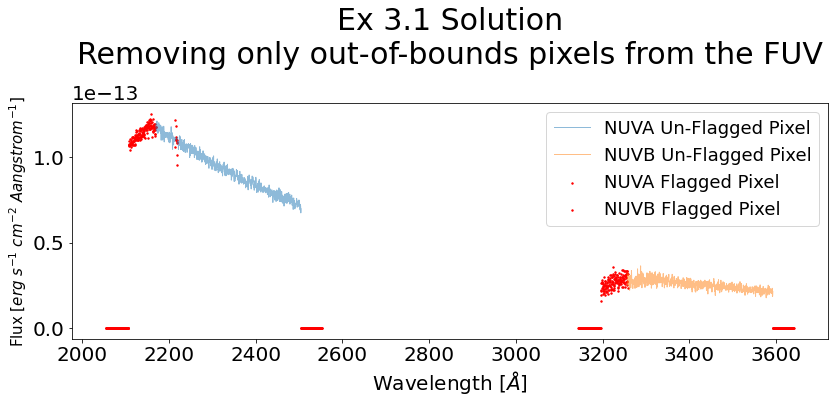

In [36]:
# Ex. 3.1 Soln

plt.figure(figsize = (12,6))
for i in range(2):
    dataQual = nuv_x1d_data[i]["DQ"]
    wvln, flux, fluxErr, segment = nuv_x1d_data[i]["WAVELENGTH"], nuv_x1d_data[i]["FLUX"],\
    nuv_x1d_data[i]["ERROR"], nuv_x1d_data[i]["SEGMENT"]


    plt.plot(wvln[dataQual == 0], flux[dataQual == 0], linewidth = 1, alpha = 0.5, 
             label = f"{segment} Un-Flagged Pixel")
    plt.scatter(wvln[dataQual != 0], flux[dataQual != 0], s = 2, c = 'r', alpha = 1, 
                label = f"{segment} Flagged Pixel")
plt.legend(fontsize = 18)
plt.title("Ex 3.1 Solution\nRemoving only out-of-bounds pixels from the FUV\n", size = 30)
plt.xlabel('Wavelength [$\AA$]', size = 20)
plt.ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 15)
plt.tight_layout()

First, Binning the data by  3
function `BinByResel` is Binning by 3
Out of range on 0-th segment with limits: 2055.2227946721123 2551.202543205818
In range on 1-th segment with limits: 3144.4680068817165 3639.1168209501548 
Unweighted mean SNR over the range [3400, 3450] is: 16.934038162231445
Out of range on 2-th segment with limits: 2141.381207452109 2387.0087020695464


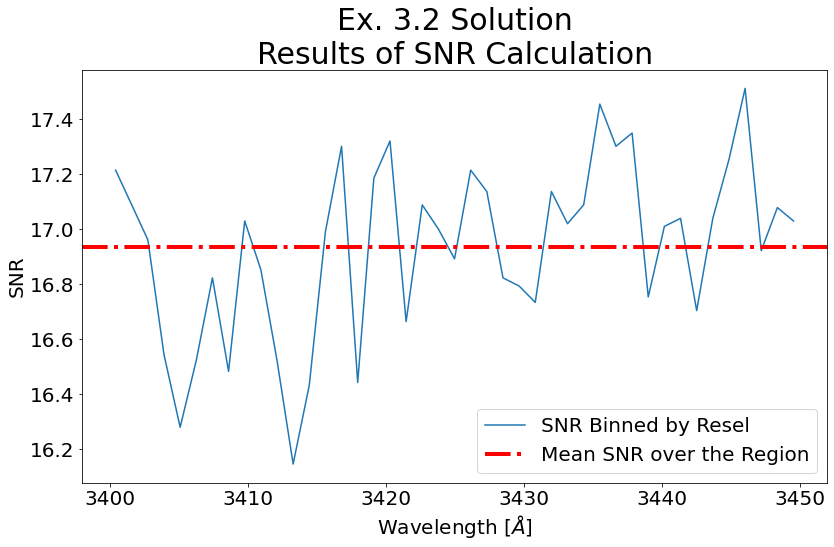

In [37]:
#Ex. 3.2 Soln

# This whole process can be accomplished in one line, provided we use Fig 2.6 to find a line free region.
# We use the estimate_SNR function to bin by teh NUV resel size of 3, then mean calculate SNR over the region.

meanSNR_nuv_range, nuv_range = estimate_SNR(nuv_x1d_data, bin_data_first=True, binsize_=3, snr_range = [3400,3450])

# Let's plot it as in Fig 3.5

plt.figure(figsize = (12,8))
plt.plot(nuv_range[1][0], nuv_range[1][1], label = "SNR Binned by Resel")
plt.axhline(meanSNR_nuv_range, c = 'r', linestyle = '-.', linewidth = 4, label = "Mean SNR over the Region")
plt.legend(fontsize = 20)
plt.title("Ex. 3.2 Solution\nResults of SNR Calculation", size = 30)
plt.xlabel('Wavelength [$\AA$]', size = 20)
plt.ylabel('SNR', size = 20)
plt.tight_layout()